In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### fetch lending market data

In [35]:
import requests 
import pandas as pd


def retrieve_lending_market(chain: str ='ethereum', controller_address: str = '0xeda215b7666936ded834f76f3fbc6f323295110a'):
    url = f'https://prices.curve.fi/v1/lending/markets/{chain}/{controller_address}/snapshots?fetch_on_chain=false&agg=day'
    r = requests.get(url)
    df =  pd.json_normalize(r.json()['data'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])  
    return df 


df = retrieve_lending_market()

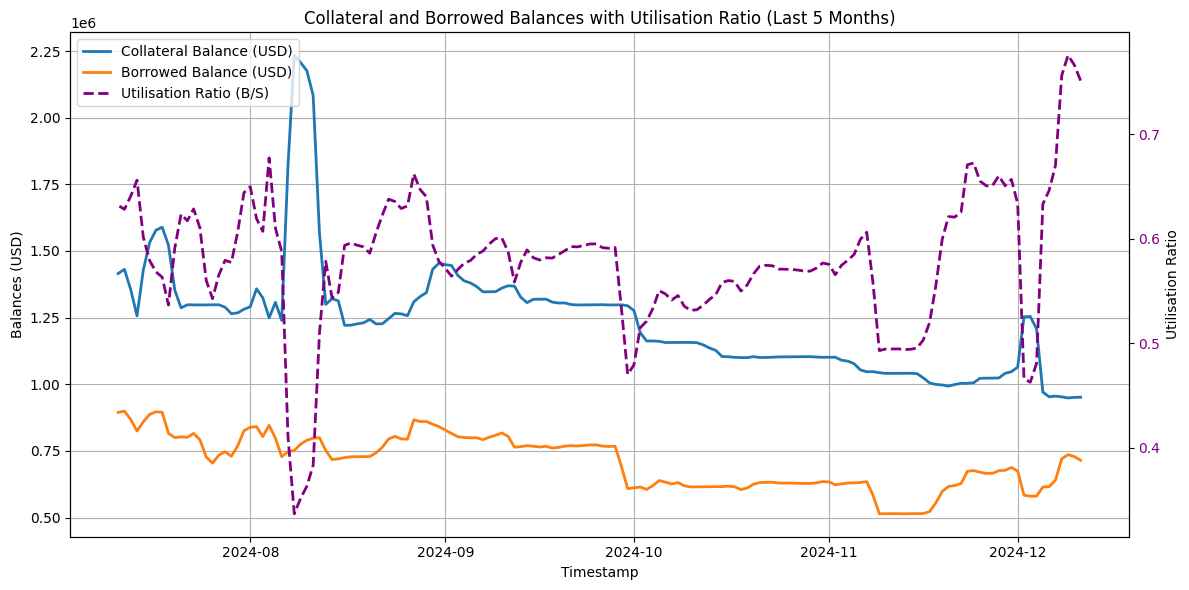

In [36]:
import matplotlib.pyplot as plt

# Calculate the utilization ratio (B/S)
df['utilisation_ratio'] = df['total_debt_usd'] / df['total_assets_usd']

# Filter data for plotting
plot_data = df[['timestamp', 'total_assets_usd', 'total_debt_usd', 'utilisation_ratio']].dropna()

filtered_data = plot_data[plot_data['timestamp'] >= plot_data['timestamp'].max() - pd.DateOffset(months=5)]

# Create a figure with twin axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot total_assets_usd and total_debt_usd on the left y-axis
line1, = ax1.plot(filtered_data['timestamp'], filtered_data['total_assets_usd'], label='Collateral Balance (USD)', linewidth=2)
line2, = ax1.plot(filtered_data['timestamp'], filtered_data['total_debt_usd'], label='Borrowed Balance (USD)', linewidth=2)
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Balances (USD)')
ax1.tick_params(axis='y')

# Create a second y-axis for utilisation ratio
ax2 = ax1.twinx()
line3, = ax2.plot(filtered_data['timestamp'], filtered_data['utilisation_ratio'], label='Utilisation Ratio (B/S)', color='purple', linewidth=2, linestyle='--')
ax2.set_ylabel('Utilisation Ratio')
ax2.tick_params(axis='y', labelcolor='purple')

# Combine legends from both axes
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

# Set title and grid
plt.title('Collateral and Borrowed Balances with Utilisation Ratio (Last 5 Months)')
ax1.grid()

# Show the plot
plt.tight_layout()
plt.show()

### Model 
We adapt the model for empricial parameterisation from Bertucci et al. (2024). We validate by constructing multiple utilization paths using the semilog policy as defined in 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import skew, kurtosis, shapiro
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import durbin_watson
from src.interest_rate_models.semilog_irm import SemiLogIRM

########################################
# STEP 1: LOAD AND PREPARE DATA
########################################

df['borrowAPR'] = (df['rate'] * 365 * 86400) / 1e18
df = df[(df['utilisation_ratio'] > 0) & (df['utilisation_ratio'] < 1) & (df['borrowAPR'] > 0)]
df = df.sort_values(by='timestamp').reset_index(drop=True)

# Logit transform of utilization
def logit(u):
    return np.log(u/(1-u))

def inv_logit(w):
    return 1/(1+np.exp(-w))

df['W'] = df['utilisation_ratio'].apply(logit)

########################################
# STEP 2: Set up SEMI-LOG IRM
########################################

rate_model = SemiLogIRM(rate_min = 0.0001, rate_max= 10) # current market parameters
rate_function = rate_model.calculate_rate

########################################
# STEP 3: ESTIMATE W MODEL
########################################
# We'll model:
# W_t = alpha + rho*W_{t-1} - b1*r(U_{t-1}) + epsilon_t

df['W_lag'] = df['W'].shift(1)
df.dropna(inplace=True)

# Compute r(U_{t-1})
# We have W_{t-1}, invert to get U_{t-1}
df['U_lag'] = inv_logit(df['W_lag'])
df['r_u_lag'] = df['U_lag'].apply(rate_function)

X_w = df[['W_lag', 'r_u_lag']].values
y_w = df['W'].values

model_w = LinearRegression()
model_w.fit(X_w, y_w)

alpha = model_w.intercept_
rho, neg_b1 = model_w.coef_
b1 = -neg_b1

residuals = y_w - model_w.predict(X_w)
sigma = residuals.std()

print("Estimated W model parameters:")
print(f"alpha = {alpha}")
print(f"rho = {rho}")
print(f"b1 = {b1}")
print(f"sigma = {sigma}")

########################################
# STEP 4: SIMULATE SYNTHETIC W PATHS AND INVERT BACK TO U
########################################
num_steps = len(df)
W0 = df['W'].iloc[0]
num_paths = 1000

sim_W_paths = np.zeros((num_paths, num_steps))
for i in range(num_paths):
    W_sim = np.zeros(num_steps)
    W_sim[0] = W0
    for t in range(1, num_steps):
        current_w = W_sim[t-1]
        # Compute current U from W
        current_u = inv_logit(current_w)
        r_current = rate_function(current_u)
        # W_t = alpha + rho*W_{t-1} - b1*r(U_{t-1}) + sigma * Z
        W_t = alpha + rho*current_w - b1*r_current + sigma*np.random.randn()
        W_sim[t] = W_t
    sim_W_paths[i,:] = W_sim

# Convert back to U
sim_paths = inv_logit(sim_W_paths)
avg_sim_path = sim_paths.mean(axis=0)
emp_util = df['utilisation_ratio'].values






Estimated W model parameters:
alpha = 0.06293803016457766
rho = 0.8937540249850904
b1 = 0.1216839498024702
sigma = 0.2711157604772773


Empirical metrics:
Mean: 0.6283956603506047
Std Dev: 0.12247313549326691
Skewness: -0.3133289326308004
Kurtosis: 1.3680527813429588

Averaged Simulated Metrics (across all paths):
Mean: 0.6305147900293636
Std Dev: 0.12465182018675497
Skewness: -0.34897207540026676
Kurtosis: -0.3508267469764952


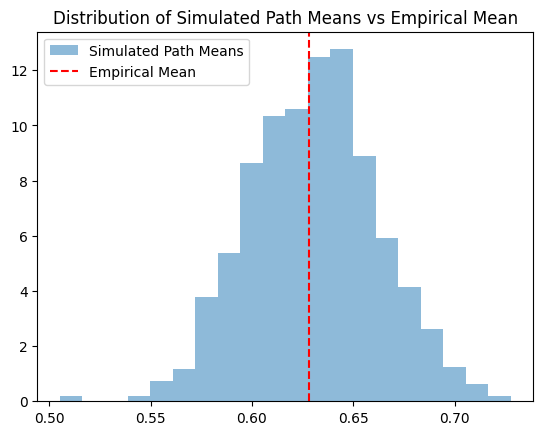

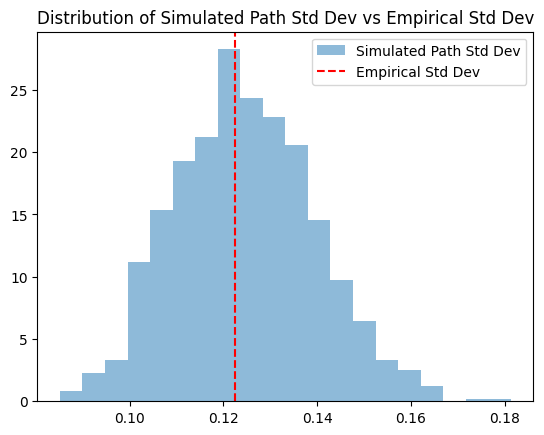

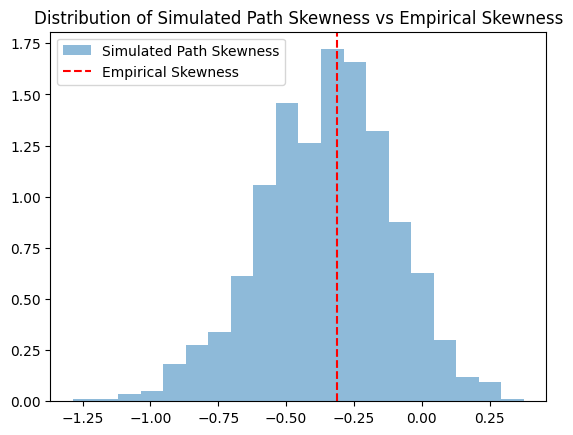

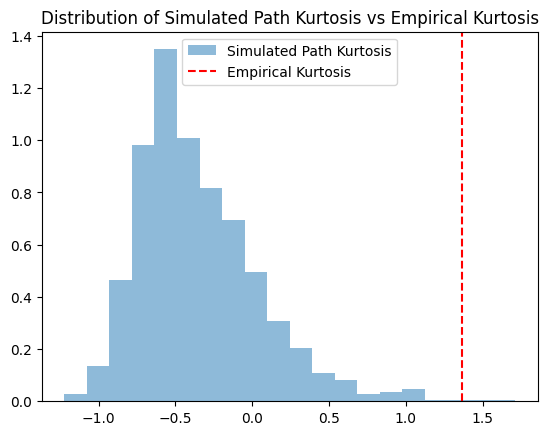

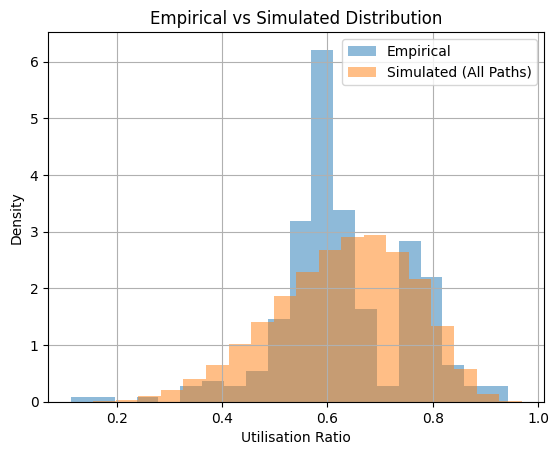

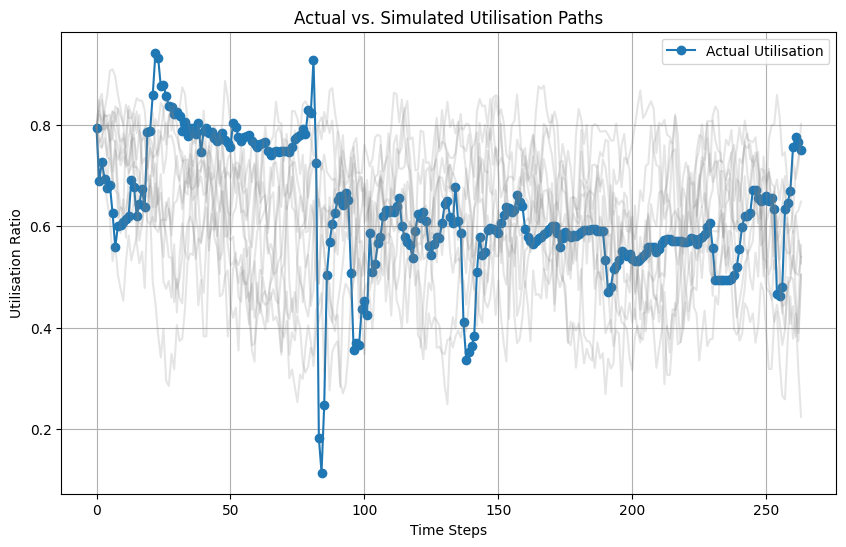

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, shapiro
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson

# Compute empirical metrics
emp_mean = np.mean(emp_util)
emp_std = np.std(emp_util)
emp_skew = skew(emp_util)
emp_kurt = kurtosis(emp_util)

print("Empirical metrics:")
print(f"Mean: {emp_mean}")
print(f"Std Dev: {emp_std}")
print(f"Skewness: {emp_skew}")
print(f"Kurtosis: {emp_kurt}")

# Compute metrics for each simulated path
num_paths = sim_paths.shape[0]
sim_means = np.zeros(num_paths)
sim_stds = np.zeros(num_paths)
sim_skews = np.zeros(num_paths)
sim_kurts = np.zeros(num_paths)

for i in range(num_paths):
    path = sim_paths[i, :]
    sim_means[i] = np.mean(path)
    sim_stds[i] = np.std(path)
    sim_skews[i] = skew(path)
    sim_kurts[i] = kurtosis(path)

# Average metrics across all simulated paths
avg_mean = np.mean(sim_means)
avg_std = np.mean(sim_stds)
avg_skew = np.mean(sim_skews)
avg_kurt = np.mean(sim_kurts)

print("\nAveraged Simulated Metrics (across all paths):")
print(f"Mean: {avg_mean}")
print(f"Std Dev: {avg_std}")
print(f"Skewness: {avg_skew}")
print(f"Kurtosis: {avg_kurt}")

########################################
# Compare empirical distribution with the distribution of path-level metrics
########################################

# One approach is to check how the distribution of metrics from simulated paths
# compares to the empirical metric. For example, you can visualize the distribution
# of means from all simulated paths and see if the empirical mean falls near the center.

plt.hist(sim_means, bins=20, alpha=0.5, density=True, label='Simulated Path Means')
plt.axvline(emp_mean, color='red', linestyle='--', label='Empirical Mean')
plt.title("Distribution of Simulated Path Means vs Empirical Mean")
plt.legend()
plt.show()

# Similarly, do the same for std, skewness, and kurtosis
plt.hist(sim_stds, bins=20, alpha=0.5, density=True, label='Simulated Path Std Dev')
plt.axvline(emp_std, color='red', linestyle='--', label='Empirical Std Dev')
plt.title("Distribution of Simulated Path Std Dev vs Empirical Std Dev")
plt.legend()
plt.show()

plt.hist(sim_skews, bins=20, alpha=0.5, density=True, label='Simulated Path Skewness')
plt.axvline(emp_skew, color='red', linestyle='--', label='Empirical Skewness')
plt.title("Distribution of Simulated Path Skewness vs Empirical Skewness")
plt.legend()
plt.show()

plt.hist(sim_kurts, bins=20, alpha=0.5, density=True, label='Simulated Path Kurtosis')
plt.axvline(emp_kurt, color='red', linestyle='--', label='Empirical Kurtosis')
plt.title("Distribution of Simulated Path Kurtosis vs Empirical Kurtosis")
plt.legend()
plt.show()


# Flatten the simulated paths array to include all values
all_sim_values = sim_paths.flatten()

# Distribution Comparison
plt.hist(emp_util, alpha=0.5, label='Empirical', bins=20, density=True)
plt.hist(all_sim_values, alpha=0.5, label='Simulated (All Paths)', bins=20, density=True)
plt.title("Empirical vs Simulated Distribution")
plt.xlabel("Utilisation Ratio")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


# Paths Comparison
plt.figure(figsize=(10,6))
plt.plot(range(num_steps), emp_util, label='Actual Utilisation', marker='o')
# plt.plot(range(num_steps), avg_sim_path, label='Average Simulated Utilisation', linestyle='--')
for i in range(min(num_paths, 10)):
    plt.plot(range(num_steps), sim_paths[i,:], color='gray', alpha=0.2)
plt.xlabel('Time Steps')
plt.ylabel('Utilisation Ratio')
plt.title('Actual vs. Simulated Utilisation Paths')
plt.legend()
plt.grid(True)
plt.show()



Estimated Dynamic Model Parameters:
A (autoregressive coefficient): -0.4484579317729892
C (utilisation effect coefficient): 0.6143550295125445
Intercept (should be ~ A*r0 + C*r1): 0.009219473742009751
Expected Intercept (A*r0 + C*r1): 0.016900073254387027
Sigma (std dev of residuals): 0.2704592243130233

Empirical Metrics:
Mean Utilization: 0.6299664443452504
Std Dev Utilization: 0.12334106740995956
Skewness: -0.30597938899950694
Kurtosis: 1.291462180059213

Averaged Simulated Metrics (across all paths):
Mean Utilization: 0.583640036625995
Std Dev Utilization: 0.19012618860246824
Skewness: -0.4753491330692759
Kurtosis: -0.28755226066622946


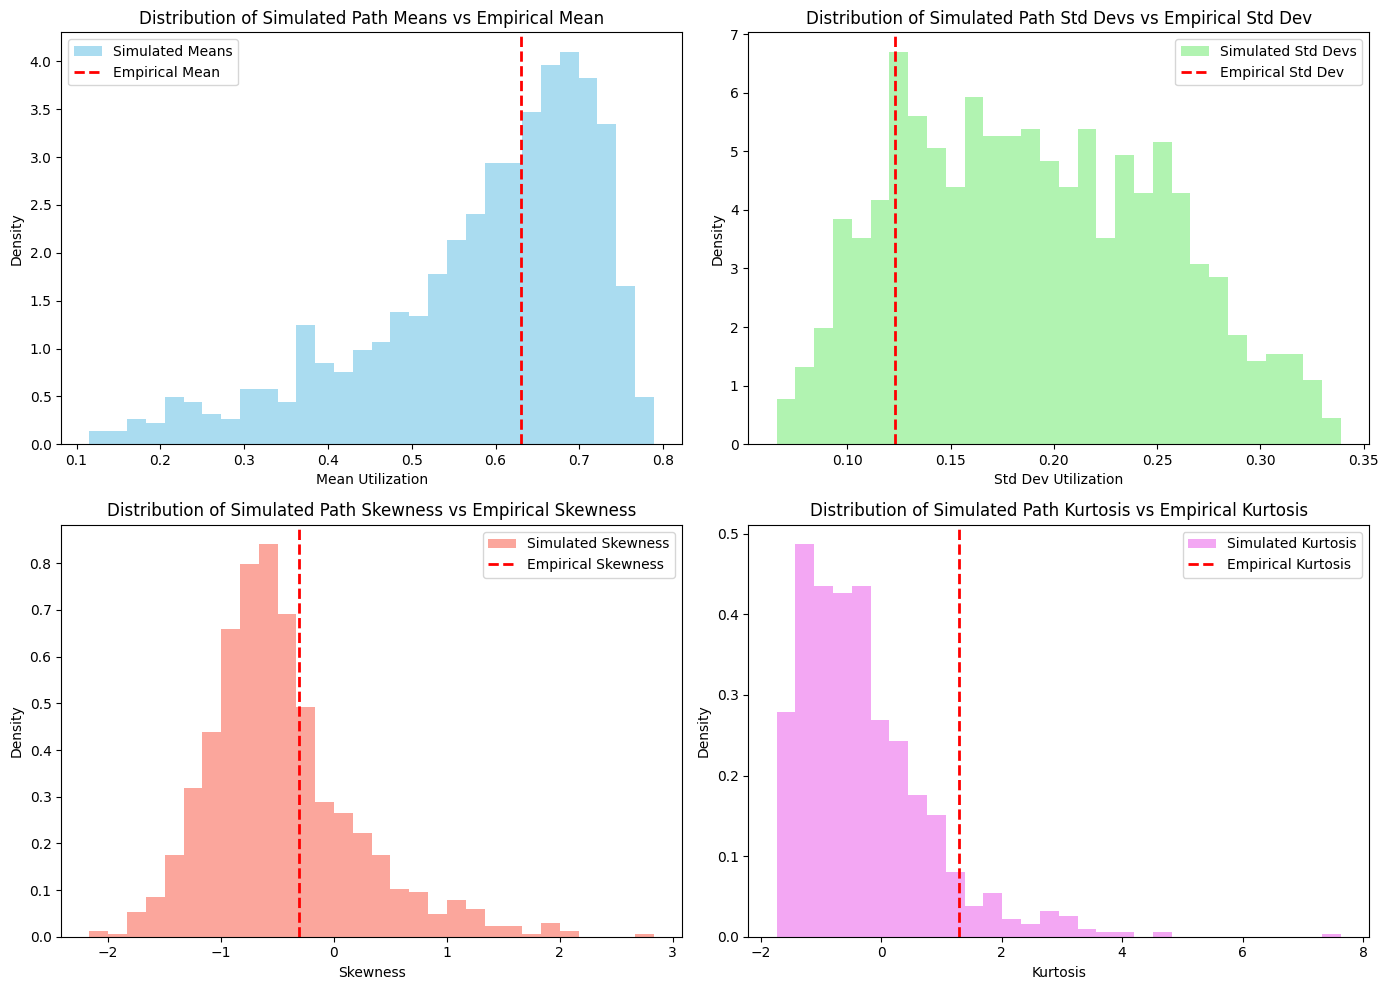

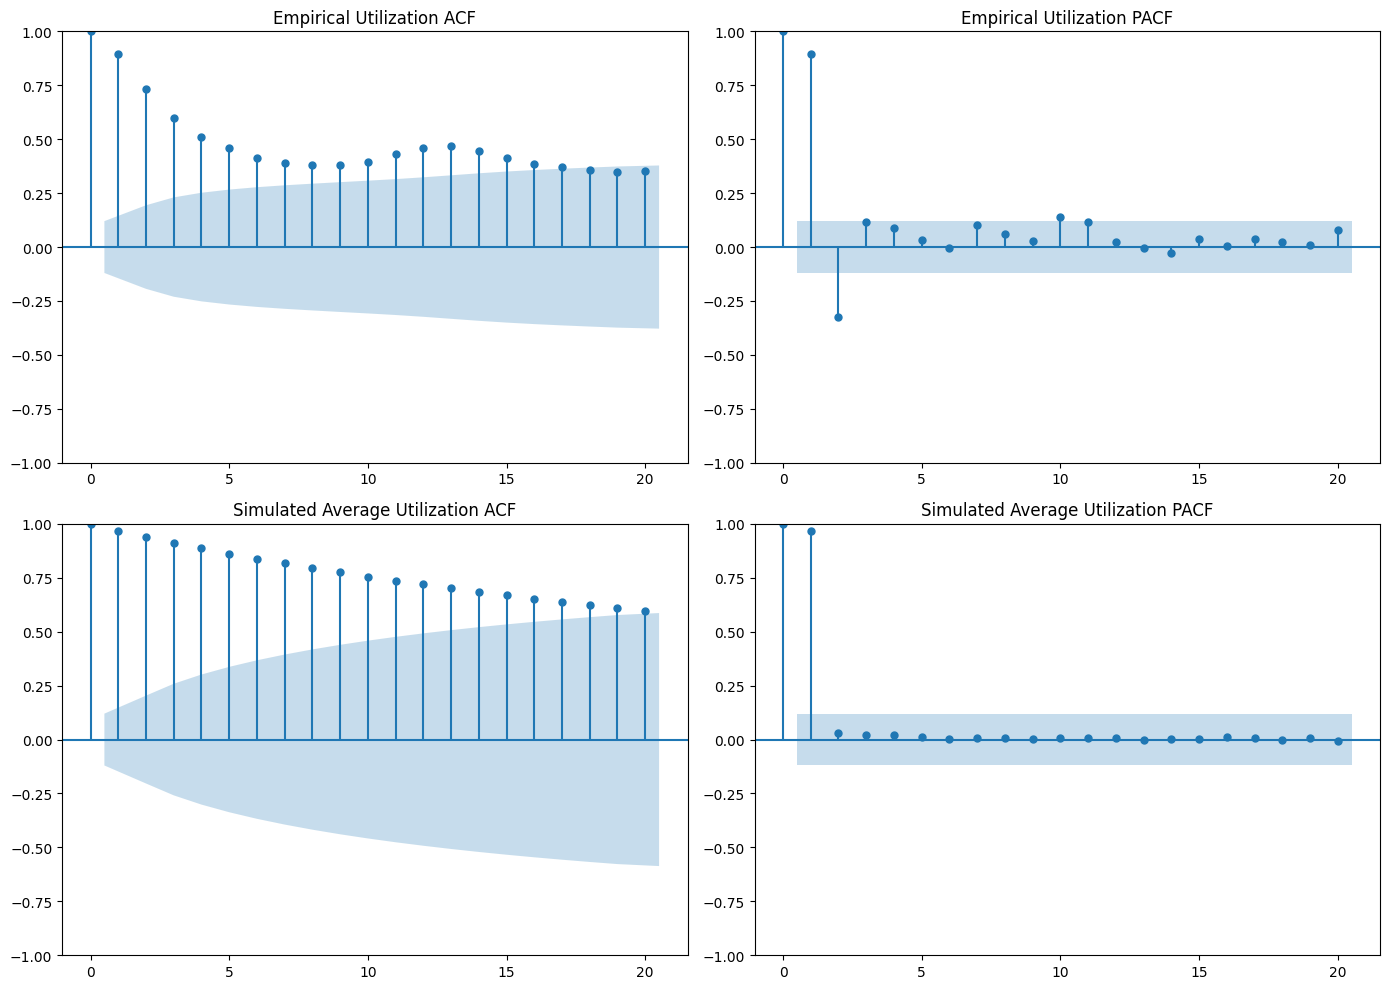


Residuals Shapiro-Wilk Test:
Statistic: 0.6381541061609395
P-value: 2.262838251837995e-23
Durbin-Watson Statistic: 1.4228485737980892


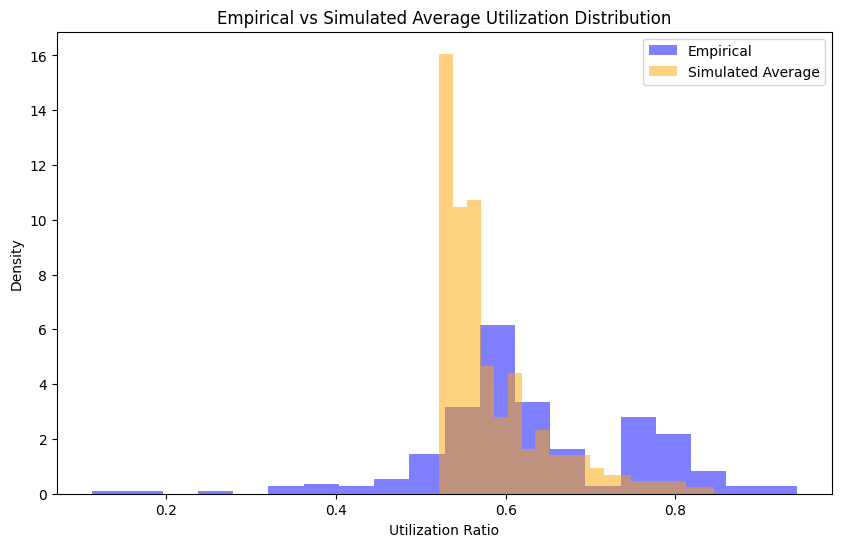

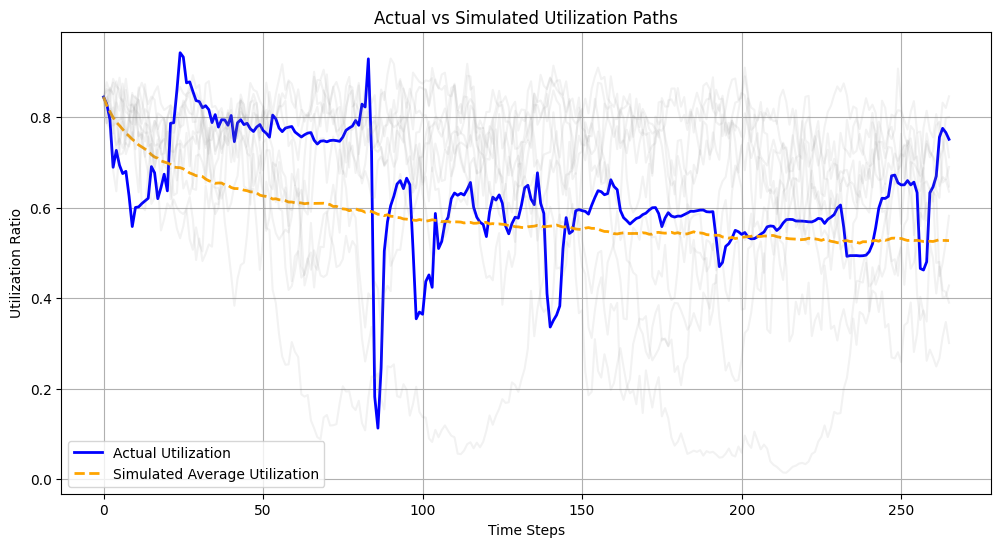

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import skew, kurtosis, shapiro
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson

# Assuming the SemiLogIRM class is correctly implemented and available
# Replace with your actual import path
from src.interest_rate_models.semilog_irm import SemiLogIRM

########################################
# STEP 1: LOAD AND PREPARE DATA
########################################



# Convert rate to borrowAPR as per provided formula
df['borrowAPR'] = (df['rate'] * 365 * 86400) / 1e18

# Filter data: utilisation between 0 and 1, and positive borrowAPR
df = df[(df['utilisation_ratio'] > 0) & (df['utilisation_ratio'] < 1) & (df['borrowAPR'] > 0)]

# Sort by timestamp and reset index
df = df.sort_values(by='timestamp').reset_index(drop=True)

# Logit transformation functions with clipping to prevent U from reaching 0 or 1
def logit(u):
    return np.log(u / (1 - u))

def inv_logit(w):
    # Clip W to prevent U from being exactly 0 or 1
    w_clipped = np.clip(w, -10, 10)  # Adjust the range as needed
    return 1 / (1 + np.exp(-w_clipped))

# Apply logit transformation
df['W'] = df['utilisation_ratio'].apply(logit)

########################################
# STEP 2: Set up Interest Rate Model (IRM)
########################################

# Initialize SemiLogIRM with current market parameters
# Adjust rate_min and rate_max based on initial fits if necessary
rate_model = SemiLogIRM(rate_min=0.0001, rate_max=10)
rate_function = rate_model.calculate_rate  # Ensure this method correctly computes r(U_t)

# If adopting a different IRM, initialize it here and define rate_function accordingly
# Example for a Piecewise Linear IRM:
# from src.interest_rate_models.piecewise_linear_irm import PiecewiseLinearIRM
# rate_model = PiecewiseLinearIRM(breakpoints=[0.5], slopes=[0.1, 0.3], rate_min=0.01, rate_max=0.05)
# rate_function = rate_model.calculate_rate

########################################
# STEP 3: ESTIMATE PARAMETERS FOR THE DYNAMIC MODEL
########################################

# Define reasonable values for r0 and r1 based on empirical borrowAPR
# These values can be adjusted as needed
r0 = 0.25  # Example: Borrow Alternative Rate
r1 = 0.21 # Example: Target Alternative rate

# Compute Delta_W = W(t) - W(t-1)
df['W_lag'] = df['W'].shift(1)
df['U_lag'] = inv_logit(df['W_lag'])
df['U_lag_times_r_u_lag'] = df['U_lag'] * df['r_u_lag']  # To be defined next
df['Delta_W'] = df['W'] - df['W_lag']

# Drop the first row with NaN
df.dropna(inplace=True)

# Compute r_u_lag after inv_logit and before applying rate_function
# To prevent the error, ensure U_lag is strictly between 0 and 1 due to clipping
df['r_u_lag'] = df['U_lag'].apply(rate_function)

# Define independent variables for regression
# Delta_W = A*(r0 - r(t)) - C*(U(t)*r(t) - r1) + noise
# Rearranged: Delta_W = A*r0 + C*r1 - A*r(t) - C*U(t)*r(t) + noise
# Therefore, regression variables are (-r(t), -U(t)*r(t)) with intercept (A*r0 + C*r1)
X = df[['r_u_lag']].copy()
X['U_lag_times_r_u_lag'] = df['U_lag'] * df['r_u_lag']
y = df['Delta_W']

# Fit linear regression model with intercept
model = LinearRegression()
model.fit(X, y)

# Extract coefficients
slope_A = model.coef_[0]  # Coefficient for r(t)
slope_C = model.coef_[1]  # Coefficient for U(t)*r(t)
intercept = model.intercept_

# Calculate A and C based on the regression coefficients
# From the rearranged equation:
# slope_A = -A
# slope_C = -C
A = -slope_A
C = -slope_C

# Verify intercept = A*r0 + C*r1
expected_intercept = A * r0 + C * r1
print("Estimated Dynamic Model Parameters:")
print(f"A (autoregressive coefficient): {A}")
print(f"C (utilisation effect coefficient): {C}")
print(f"Intercept (should be ~ A*r0 + C*r1): {intercept}")
print(f"Expected Intercept (A*r0 + C*r1): {expected_intercept}")

# Calculate residuals and sigma (standard deviation of residuals)
residuals = y - model.predict(X)
sigma = residuals.std()
print(f"Sigma (std dev of residuals): {sigma}")

########################################
# STEP 4: SIMULATE SYNTHETIC UTILISATION PATHS
########################################

num_steps = len(df)
W0 = df['W'].iloc[0]
num_paths = 1000

# Initialize simulation matrix
sim_W_paths = np.zeros((num_paths, num_steps))
sim_W_paths[:, 0] = W0

for i in range(num_paths):
    for t in range(1, num_steps):
        current_W = sim_W_paths[i, t-1]
        current_U = inv_logit(current_W)
        current_r = rate_function(current_U)
        
        # Compute Delta_W using the dynamic equation
        Delta_W = A * (r0 - current_r) - C * (current_U * current_r - r1) + sigma * np.random.randn()
        
        # Update W
        sim_W_paths[i, t] = current_W + Delta_W

# Invert logit to get U
sim_paths = inv_logit(sim_W_paths)
avg_sim_path = sim_paths.mean(axis=0)
emp_util = df['utilisation_ratio'].values

########################################
# STEP 5: VALIDATE
########################################

# Compute empirical metrics
emp_mean = np.mean(emp_util)
emp_std = np.std(emp_util)
emp_skew = skew(emp_util)
emp_kurt = kurtosis(emp_util)

print("\nEmpirical Metrics:")
print(f"Mean Utilization: {emp_mean}")
print(f"Std Dev Utilization: {emp_std}")
print(f"Skewness: {emp_skew}")
print(f"Kurtosis: {emp_kurt}")

# Compute metrics for each simulated path
sim_means = sim_paths.mean(axis=1)
sim_stds = sim_paths.std(axis=1)
sim_skews = skew(sim_paths, axis=1)
sim_kurts = kurtosis(sim_paths, axis=1)

# Average metrics across all simulated paths
avg_mean_sim = sim_means.mean()
avg_std_sim = sim_stds.mean()
avg_skew_sim = sim_skews.mean()
avg_kurt_sim = sim_kurts.mean()

print("\nAveraged Simulated Metrics (across all paths):")
print(f"Mean Utilization: {avg_mean_sim}")
print(f"Std Dev Utilization: {avg_std_sim}")
print(f"Skewness: {avg_skew_sim}")
print(f"Kurtosis: {avg_kurt_sim}")

# Distribution Comparison for Metrics
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Mean Utilization
axs[0, 0].hist(sim_means, bins=30, alpha=0.7, label='Simulated Means', color='skyblue', density=True)
axs[0, 0].axvline(emp_mean, color='red', linestyle='dashed', linewidth=2, label='Empirical Mean')
axs[0, 0].set_title('Distribution of Simulated Path Means vs Empirical Mean')
axs[0, 0].set_xlabel('Mean Utilization')
axs[0, 0].set_ylabel('Density')
axs[0, 0].legend()

# Std Dev Utilization
axs[0, 1].hist(sim_stds, bins=30, alpha=0.7, label='Simulated Std Devs', color='lightgreen', density=True)
axs[0, 1].axvline(emp_std, color='red', linestyle='dashed', linewidth=2, label='Empirical Std Dev')
axs[0, 1].set_title('Distribution of Simulated Path Std Devs vs Empirical Std Dev')
axs[0, 1].set_xlabel('Std Dev Utilization')
axs[0, 1].set_ylabel('Density')
axs[0, 1].legend()

# Skewness
axs[1, 0].hist(sim_skews, bins=30, alpha=0.7, label='Simulated Skewness', color='salmon', density=True)
axs[1, 0].axvline(emp_skew, color='red', linestyle='dashed', linewidth=2, label='Empirical Skewness')
axs[1, 0].set_title('Distribution of Simulated Path Skewness vs Empirical Skewness')
axs[1, 0].set_xlabel('Skewness')
axs[1, 0].set_ylabel('Density')
axs[1, 0].legend()

# Kurtosis
axs[1, 1].hist(sim_kurts, bins=30, alpha=0.7, label='Simulated Kurtosis', color='violet', density=True)
axs[1, 1].axvline(emp_kurt, color='red', linestyle='dashed', linewidth=2, label='Empirical Kurtosis')
axs[1, 1].set_title('Distribution of Simulated Path Kurtosis vs Empirical Kurtosis')
axs[1, 1].set_xlabel('Kurtosis')
axs[1, 1].set_ylabel('Density')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

# # Autocorrelation Function (ACF) and Partial ACF (PACF) Plots
# fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# # Empirical ACF and PACF
# plot_acf(emp_util, ax=axes[0, 0], lags=20)
# axes[0, 0].set_title('Empirical Utilization ACF')
# plot_pacf(emp_util, ax=axes[0, 1], lags=20, method='ywm')
# axes[0, 1].set_title('Empirical Utilization PACF')

# # Simulated Average Path ACF and PACF
# plot_acf(avg_sim_path, ax=axes[1, 0], lags=20)
# axes[1, 0].set_title('Simulated Average Utilization ACF')
# plot_pacf(avg_sim_path, ax=axes[1, 1], lags=20, method='ywm')
# axes[1, 1].set_title('Simulated Average Utilization PACF')

# plt.tight_layout()
# plt.show()

# Residual Diagnostics
stat, p_value = shapiro(residuals)
print("\nResiduals Shapiro-Wilk Test:")
print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat}")

# Distribution Comparison of Utilization
plt.figure(figsize=(10, 6))
plt.hist(emp_util, bins=20, alpha=0.5, label='Empirical', color='blue', density=True)
plt.hist(avg_sim_path, bins=20, alpha=0.5, label='Simulated Average', color='orange', density=True)
plt.title("Empirical vs Simulated Average Utilization Distribution")
plt.xlabel("Utilization Ratio")
plt.ylabel("Density")
plt.legend()
plt.show()

# Paths Comparison
plt.figure(figsize=(12, 6))
plt.plot(range(num_steps), emp_util, label='Actual Utilization', color='blue', linewidth=2)
plt.plot(range(num_steps), avg_sim_path, label='Simulated Average Utilization', color='orange', linestyle='--', linewidth=2)
# Plot a subset of simulated paths for visualization
for i in range(10):
    plt.plot(range(num_steps), sim_paths[i, :], color='gray', alpha=0.1)
plt.xlabel('Time Steps')
plt.ylabel('Utilization Ratio')
plt.title('Actual vs Simulated Utilization Paths')
plt.legend()
plt.grid(True)
plt.show()
